In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
info_job_level_dfs = {}
spatial_job_level_dfs = {}
info_gpu_level_dfs = {}
info_job_level_dfs["gpu_utilization"] = pd.read_csv("job_level_gpu_utilization.csv")
spatial_job_level_dfs["gpu_utilization"] = pd.read_csv("spatial_job_level_gpu_utilization.csv") 
info_gpu_level_dfs["gpu_utilization"] = pd.read_csv("gpu_level_gpu_utilization.csv")

In [3]:
gputil_all = info_job_level_dfs["gpu_utilization"]

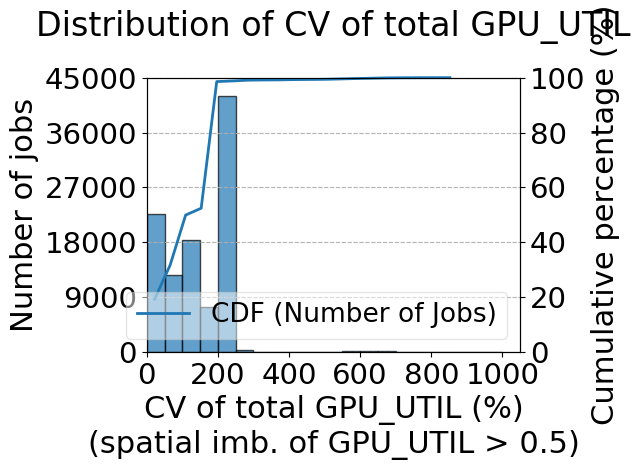

In [4]:
high_spatial_imbalance_jobs = spatial_job_level_dfs["gpu_utilization"][spatial_job_level_dfs["gpu_utilization"]["spatial_imbalance_gpu_utilization"] > 0.5]
high_spatial_gpu_level = info_gpu_level_dfs["gpu_utilization"][info_gpu_level_dfs["gpu_utilization"]["jobid"].isin(list(high_spatial_imbalance_jobs["jobid"]))]
cv_total_utilization = (
    high_spatial_gpu_level.groupby("jobid")["total_utilization"]
    .agg(["mean", "std"])
    .reset_index()
)

cv_total_utilization["cv"] = (cv_total_utilization["std"] / cv_total_utilization["mean"]) * 100

hist_values, bin_edges = np.histogram(cv_total_utilization['cv'], bins=20, density=False)
cumulative_hist = np.cumsum(hist_values)
cdf = cumulative_hist / cumulative_hist[-1] * 100 

fig, ax1 = plt.subplots()
ax1.hist(cv_total_utilization['cv'], bins=20, range=(0, 1000), edgecolor='black', alpha=0.7)
ax1.set_ylabel('Number of jobs', fontsize=22)
ax1.set_xlim(0)
ax1.set_xticks([0, 200, 400, 600, 800, 1000])
ax1.set_xlabel("CV of total GPU_UTIL (%)\n(spatial imb. of GPU_UTIL > 0.5)", fontsize=22)
ax1.set_yticks([0, 9000, 18000, 27000, 36000, 45000])
ax1.set_ylim(0, 45000)
ax1.tick_params(axis='x', labelsize=21)
ax1.tick_params(axis='y', labelsize=21)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

ax2 = ax1.twinx()
ax2.plot((bin_edges[:-1] + bin_edges[1:]) / 2, cdf, label='CDF (Number of Jobs)', linewidth=2, clip_on=False)
ax2.set_ylabel('Cumulative percentage (%)', fontsize=22)

ax2.tick_params(axis='y')
ax2.grid(axis='y', linestyle='--', alpha=0.7)
ax2.set_yticks([0, 20, 40, 60, 80, 100])
ax2.set_ylim(0, 100)
ax2.tick_params(axis='x', labelsize=21)
ax2.tick_params(axis='y', labelsize=21)
plt.legend(loc="lower right", fontsize=19, framealpha=0.5)

plt.title("Distribution of CV of total GPU_UTIL", fontsize=24, pad=30)
plt.tight_layout()
plt.show()
plt.close()

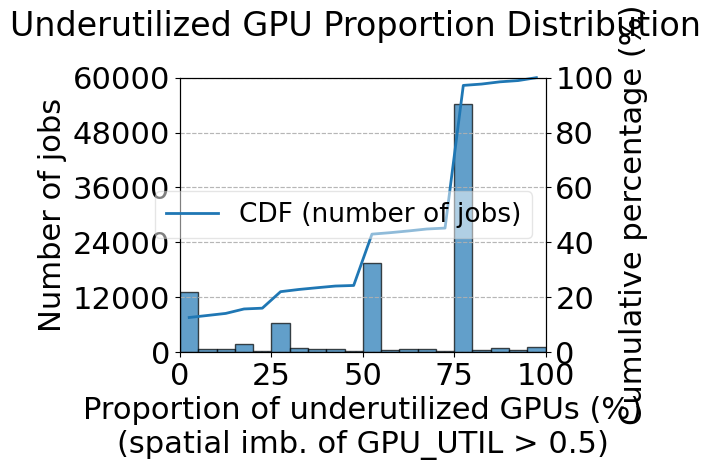

In [5]:
def calculate_underutilized_proportion_max(group, deviation_threshold=0.5):
    max_utilization = group['total_utilization'].max()
    underutilized = group['total_utilization'] < (1 - deviation_threshold) * max_utilization
    proportion = (underutilized.sum() / len(group)) * 100
    return proportion

gputil_underutilized_dynamic = (
    high_spatial_gpu_level.groupby("jobid")
    .apply(calculate_underutilized_proportion_max)
    .reset_index(name="proportion_below_threshold")
)

hist_values, bin_edges = np.histogram(
    gputil_underutilized_dynamic["proportion_below_threshold"], bins=20, range=(0, 100), density=False
)
cumulative_hist = np.cumsum(hist_values)
cdf = cumulative_hist / cumulative_hist[-1] * 100 

fig, ax1 = plt.subplots()

# Plot the histogram
ax1.hist(
    gputil_underutilized_dynamic["proportion_below_threshold"],
    bins=20,
    range=(0, 100),
    edgecolor="black",
    alpha=0.7,
    label="Histogram",
)
ax1.set_xlabel("Proportion of underutilized GPUs (%)\n(spatial imb. of GPU_UTIL > 0.5)", fontsize=22)
ax1.set_ylabel("Number of jobs", fontsize=22)
ax1.set_xlim(0, 1)
ax1.set_yticks([0, 12000, 24000, 36000, 48000, 60000])
ax1.set_ylim(0, 60000)
ax1.grid(axis="y", linestyle="--", alpha=0.7)
ax1.tick_params(axis='x', labelsize=22)
ax1.tick_params(axis='y', labelsize=22)

ax2 = ax1.twinx()
ax2.plot(
    (bin_edges[:-1] + bin_edges[1:]) / 2,  # Bin centers
    cdf,
    label='CDF (number of jobs)', linewidth=2, clip_on=False
)
ax2.set_ylabel("Cumulative percentage (%)", fontsize=22)
ax2.set_yticks([0, 20, 40, 60, 80, 100])
ax2.tick_params(axis="y")
ax2.grid(axis="y", linestyle="--", alpha=0.7)
ax2.set_xticks([0, 25, 50, 75, 100])
ax2.set_ylim(0, 100)

ax2.tick_params(axis='x', labelsize=22)
ax2.tick_params(axis='y', labelsize=22)
plt.legend(loc="center right", fontsize=19, framealpha=0.5)

plt.title("Underutilized GPU Proportion Distribution", fontsize=24, pad=30, x=0.48)
plt.tight_layout()
plt.show()
